## Preparing the dataset
- load the data
- rename the columns
- split the dataset into train and test (test will be used only at the very final step)
- separate the independent variables from the target variables

In [2]:
import pandas as pd
import numpy as np

# load the data
leaf = pd.read_csv("leaf.csv" , header = None)

# rename the columns
names = np.array(["Class", "Specimen", "Eccentricity", "Aspect Ratio", "Elongation",
                  "Solidity", "Stochastic Convexity", "Isoperimetric Factor",
                  "Maximal Indentation Depth ","Lobedness","Average Intensity",
                  "Average Contrast","Smoothness","Third moment","Uniformity","Entropy"])
leaf.columns = names

data = leaf.loc[:, leaf.columns != 'Specimen']

"""
# split the dataset into train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, random_state = 5, test_size = 0.2, stratify = data['Class'])
train.index = np.linspace(0, len(train)-1, len(train), dtype = 'int')
test.index = np.linspace(0, len(test)-1, len(test), dtype = 'int')


# separate the independent variables from the target variables
X = train.loc[:, train.columns != 'Class']
y = train['Class']
"""

X = data.loc[:, data.columns != 'Class']
y = data['Class']

## Building some useful tools
- declaring two cross-validation loop: 
    - outer stratified cv-loop
    - inner non-stratified cv-loop
- set the scoring we'd like to compute (this tuple will be used inside 'do_cross_validation')
- definition of do_cross_validation: it evaluate metric(s) by cross-validation and also record fit/score times, then print result(s).

### Decide the metric to use
Micro average F1 score performs worse on imbalanced datasets than macro average F1 score. The reason for this is because micro F1 gives equal importance to each observation, whilst macro F1 gives each class equal importance.
When micro F1 score gives equal importance to each observation this means that when the classes are imbalanced, those classes with more observations will have a larger impact on the final score. Resulting in a final score which hides the performance of the minority classes and amplifies the majority.
On the other hand, macro F1 score gives equal importance to each class. This means that a majority class will contribute equally along with the minority, allowing macro f1 to still return objective results on imbalanced datasets.

## Stratified?
- Paper: https://arxiv.org/pdf/1811.12808.pdf
- Code: https://github.com/rasbt/model-eval-article-supplementary/blob/master/code/nested_cv_code.ipynb

Here he uses stratified K Fold both for inner and outer CV

In [3]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, KFold, LeaveOneOut, cross_validate

# declaring two cross-validation loop
inner_cv = StratifiedKFold(n_splits = 5) # random_state = 10)
outer_cv = StratifiedKFold(n_splits = 5, shuffle = True)

# set the scoring
#scoring = ('f1_weighted', 'accuracy', 'f1_macro', 'f1_micro', 'roc_auc_ovo_weighted', 'roc_auc_ovr_weighted')
scoring = ('f1_macro', 'f1_weighted')
# definition of do_cross_validation
def do_cross_validation(clf,X=X, y=y, print_model=True, scoring = scoring):
    cv = cross_validate(clf, X, y, scoring=scoring, cv= outer_cv, return_train_score=False)

    for i in range(len(scoring)):
        scores = ' + '.join(f'{s:.2f}' for s in cv['test_' + scoring[i]])
        mean_ = cv['test_' + scoring[i]].mean()
        msg = f'Cross-validated {scoring[i]}: ({scores}) / {outer_cv.n_splits} = {mean_:.2f}'
        if print_model:
            msg = f'{clf}:\n\t{msg}\n'
        print(msg)

In [4]:
from sklearn.model_selection import GridSearchCV

## Single tree (ADDED)
Use 'min_samples_leaf' and impurity measures ('criterion').

The paper, "An empirical study on hyperparameter tuning of decision trees" states that the ideal min_samples_leaf values tend to be between 1 to 20 (https://arxiv.org/pdf/1812.02207.pdf)

" I think one exception to this is when you have an imbalanced class problem because then the regions in which the minority class will be in majority will be very small so you should go with a lower value." (https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680#:~:text=further%20in%20min_impurity_decrease.-,The%20paper%2C%20An%20empirical%20study%20on%20hyperparameter%20tuning%20of%20decision,20%20for%20the%20CART%20algorithm.)

Our dataset is not so large so I suggest to use not so big values for 'min_samples_leaf'.

https://scikit-learn.org/stable/modules/tree.html

In [5]:
from sklearn.tree import DecisionTreeClassifier
# tree inner loop
param_grid={'min_samples_leaf': [1, 2, 5, 10, 15] , 'criterion': ["gini", "entropy"]}
clf_grid = GridSearchCV(DecisionTreeClassifier(random_state = 0), param_grid=param_grid, cv = inner_cv, n_jobs=4)
# tree outer loop
do_cross_validation(clf_grid)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [1, 2, 5, 10, 15]}):
	Cross-validated f1_macro: (0.69 + 0.60 + 0.50 + 0.66 + 0.58) / 5 = 0.61

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [1, 2, 5, 10, 15]}):
	Cross-validated f1_weighted: (0.70 + 0.59 + 0.50 + 0.67 + 0.59) / 5 = 0.61



## Train RandomForest
- train a RandomForest by a two nested CV loop. 
    - in the outer loop we estimate the score indexes using 'do_cross_validation'
    - in the inner loop we to GridSearch

The main parameters to adjust when using Random Forest method is n_estimators and max_features.

Sklearn documentation (https://scikit-learn.org/stable/modules/ensemble.html#parameters) suggests that the option 'sqrt' (this option will take square root of the total number of features in individual each split) for 'max_features' is generally good for classification problems ('sqrt' should be the default value).
For 'n_estimators' the larger the better, but also the longer it will take to compute so we can choose some random  high values.

In [6]:
from sklearn.ensemble import RandomForestClassifier
# random forest inner loop
param_grid={'max_features': ['sqrt'], 'n_estimators':[25, 50, 100, 200, 500]}
clf_grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=param_grid, cv = inner_cv, n_jobs=4)
# random forest outer loop
do_cross_validation(clf_grid)

### questo è per la confusion matrix finale, si può togliere
clf_grid.fit(X,y) 
print(clf_grid.best_params_) 
crit= list(clf_grid.best_params_.values())[0]
n_est = list(clf_grid.best_params_.values())[1]
###


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=0), n_jobs=4,
             param_grid={'max_features': ['sqrt'],
                         'n_estimators': [25, 50, 100, 200, 500]}):
	Cross-validated f1_macro: (0.86 + 0.74 + 0.70 + 0.74 + 0.70) / 5 = 0.75

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=0), n_jobs=4,
             param_grid={'max_features': ['sqrt'],
                         'n_estimators': [25, 50, 100, 200, 500]}):
	Cross-validated f1_weighted: (0.86 + 0.72 + 0.71 + 0.75 + 0.71) / 5 = 0.75

{'max_features': 'sqrt', 'n_estimators': 200}


## Standardization

before moving to SVM and kNN, we need to standardize our independent variable. Since we are using cross validation also to assess our final performance metric we need to ensure that standardization is performed in each fold and not on the whole dataset.\
In order to do this we need to use the sklearn `pipeline` in conjunction with nested cross validation as before.\
**Performing standardization on the whole set would be wrong as we'd have information leakage from the data we use to perform our cross validation**\

When you use parameter_grid remember that the parameters must have the name of the classifier

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Train SVM with Gaussian Kernel 
- train a SVM by a two nested CV loop. 
    - in the outer loop we estimate the score indexes using 'do_cross_validation'
    - in the inner loop we to GridSearch

Hyper-paramters to consider in the grid search:
 - `gamma`: use a set of float values, sklearn documentation suggests using exponentially spaced ones (and so do other tutorials).
 - `C`: use a set of float values, sklearn documentation suggests using exponentially spaced ones (and so do other tutorials).

In [8]:
from sklearn.svm import SVC
pipeline_SVC = Pipeline([('scaler', StandardScaler()),
                        ('classifier', SVC(kernel='rbf', probability = True))]) #If we choose some scoring without probability set probability to FALSE
param_grid = {'classifier__C': np.logspace(-2, 5, 8), 'classifier__gamma' : np.logspace(-4, 3, 8)}
grid_search = GridSearchCV(pipeline_SVC, param_grid=param_grid, cv = inner_cv, n_jobs=4)

In [9]:
do_cross_validation(grid_search)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', SVC(probability=True))]),
             n_jobs=4,
             param_grid={'classifier__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
                         'classifier__gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}):
	Cross-validated f1_macro: (0.67 + 0.74 + 0.79 + 0.73 + 0.80) / 5 = 0.75

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', SVC(probability=True))]),
             n_jobs=4,
             param_grid={'classifier__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
                         'classifier__gamma': array([1.e-04, 1.e-03, 1.e-

## Train SVM with Linear Kernel 
- train a SVM by a two nested CV loop. 
    - in the outer loop we estimate the score indexes using 'do_cross_validation'
    - in the inner loop we to GridSearch

Hyper-paramters to consider in the grid search:
 - `gamma`: use a set of float values, sklearn documentation suggests using exponentially spaced ones (and so do other tutorials).
 - `C`: use a set of float values, sklearn documentation suggests using exponentially spaced ones (and so do other tutorials).

### LinearSVC: possible alternative, but discard since ther's no built in probability parameter
Linear Support Vector Classification.

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.



https://medium.com/@myselfaman12345/c-and-gamma-in-svm-e6cee48626be
    
After multiple trials, we get the higher score with that value of C parameter

In [10]:
from sklearn.svm import SVC
pipeline_SVC = Pipeline([('scaler', StandardScaler()),
                        ('classifier', SVC(kernel='linear', probability=True))]) #If we choose some scoring without probability set probability to FALSE
param_grid = {'classifier__C': np.logspace(-3, 10, 10), 'classifier__decision_function_shape': ['ovo','ovr']}
grid_search = GridSearchCV(pipeline_SVC, param_grid=param_grid, cv = inner_cv, n_jobs=4)

In [11]:
do_cross_validation(grid_search)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        SVC(kernel='linear',
                                            probability=True))]),
             n_jobs=4,
             param_grid={'classifier__C': array([1.00000000e-03, 2.78255940e-02, 7.74263683e-01, 2.15443469e+01,
       5.99484250e+02, 1.66810054e+04, 4.64158883e+05, 1.29154967e+07,
       3.59381366e+08, 1.00000000e+10]),
                         'classifier__decision_function_shape': ['ovo', 'ovr']}):
	Cross-validated f1_macro: (0.73 + 0.76 + 0.69 + 0.77 + 0.82) / 5 = 0.75

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        SVC(kernel='linear',
    

## Train kNN
- train a kNN by a two nested CV loop. 
    - in the outer loop we estimate the score indexes using 'do_cross_validation'
    - in the inner loop we to GridSearch

The main hyper-parameters to consider when using kNN method is the distance ('classifier__p') and the number of neighbors ('classifier__n_neighbors').

In [12]:
from sklearn.neighbors import KNeighborsClassifier
pipeline_KNN = Pipeline([('scaler', StandardScaler()),
                        ('classifier', KNeighborsClassifier())])

# classifier_p = 1 means manhattan_distance (l1), classifier_p = 2 means euclidean_distance (l2)
param_grid = {'classifier__n_neighbors': list(range(1,15)), 'classifier__p':[1, 2]}
grid_search = GridSearchCV(pipeline_KNN, param_grid=param_grid, cv = inner_cv)

In [13]:
do_cross_validation(grid_search)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                     10, 11, 12, 13, 14],
                         'classifier__p': [1, 2]}):
	Cross-validated f1_macro: (0.68 + 0.60 + 0.66 + 0.75 + 0.69) / 5 = 0.68

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                     10, 11, 12, 13, 14],
                         'classifier__p': [1, 2]}):
	Cross-validated f1_weighted: (0.69 + 0.59 + 0.66 + 0.76

Plot a confusion matrix of a trained RF with the best parameter we've obtained.

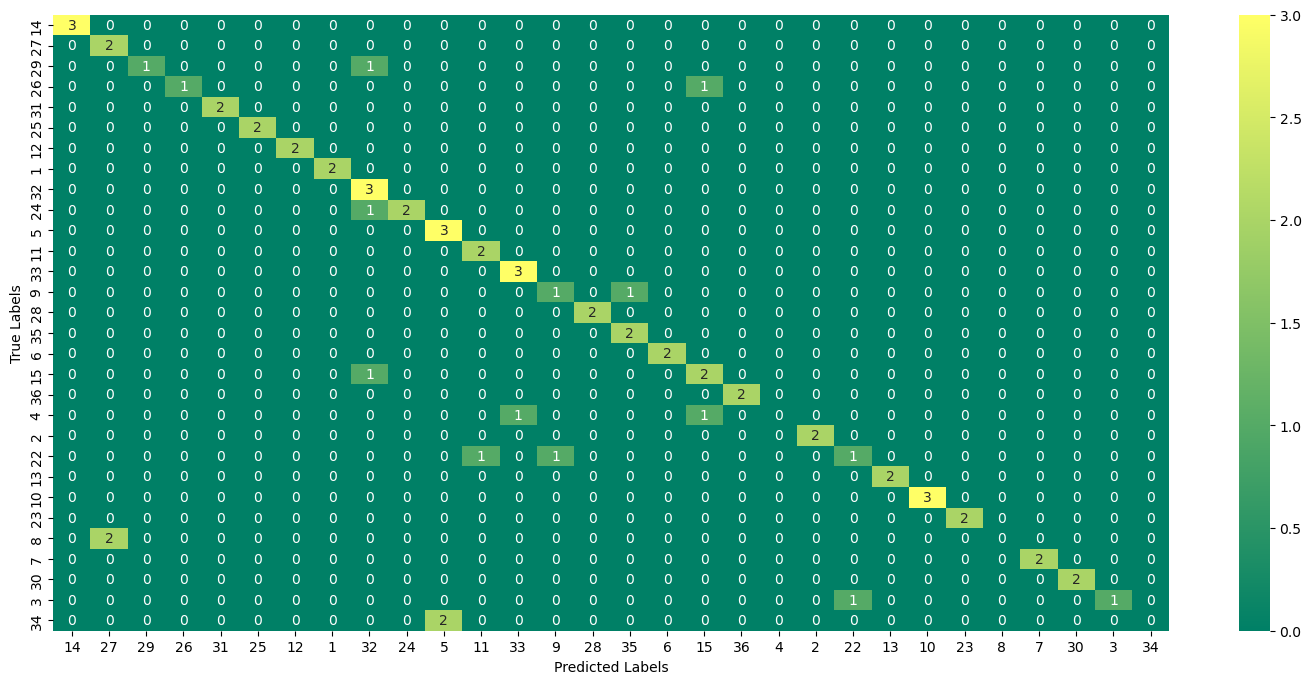

In [14]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt 

train, test = train_test_split(data, random_state = 5, test_size = 0.2, stratify = data['Class'])
train.index = np.linspace(0, len(train)-1, len(train), dtype = 'int')
test.index = np.linspace(0, len(test)-1, len(test), dtype = 'int')

X = train.loc[:, train.columns != 'Class']
y = train['Class']

X_test = test.loc[:, test.columns != 'Class']
y_test = test['Class']

tree = RandomForestClassifier(criterion='gini', n_estimators= 500)
tree.fit(X,y)
y_pred = tree.predict(X_test)

plt.figure(figsize = (18,8))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()